# Tutorial: Road damage

## Iterative Annotation Process with ipyannotator

This tutorial demonstrates how you can build an annotated dataset for road damage classification without ever leaving the
jupyter notebook / lab. We do this in three steps:

1. Use bounding box annotation to crop the orignal images.
2. Group the damage type in groups using classification labels.
3. Refine the inital class labels in a supervision step.

This steps can be applied iteratively for practical applications and significantly speed up by integrating the predictions of imperfect machine learning models.
For example we might train an image classification model on the first annotations and refine it's prediction on new data to increase the training data and repead the process again.

**Install @jupyter-widgets/jupyter-manager. To do this, go to puzzle/jigsaw symbol and install the widget manually.**

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

## Get Road Damage Images from BigData Cup 2020

First we need to retrieve some images from which we can build or data set. Fortunately the [Global Road Damage Detection Challenge 2020](https://rdd2020.sekilab.global/data/) provides
a freely usable images that we can download (Please cite [the paper](https://github.com/sekilab/RoadDamageDetector#citation) if you use this for your own work).

### Linux
The following commandas will download and prepare the images.

In [ ]:
! wget https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/test1.tar.gz

In [ ]:
! tar -xf test1.tar.gz

In [ ]:
! du -h test1/

In [ ]:
! mkdir road_japan

In [ ]:
! mv test1/Japan/images road_japan/images

In [ ]:
! rm -r test1.tar.gz test1

### Other OS

Please complete the following manual steps.

- download the test1 dataset from https://github.com/sekilab/RoadDamageDetector#dataset-for-global-road-damage-detection-challenge-2020
- unpack the `*.tar.gz` file
- create a new folder `road_japan` next to this notebook
- move the folder `test1/Japan/images` into `road_japan`

## 1) Use bounding box annotation to crop the orignal imges.

We can now use the BBoxAnnotator to quickly inspect the available images.

In [ ]:
from pathlib import Path
from ipyannotator.bbox_annotator import BBoxAnnotator
from ipyannotator.base import InputImage, OutputImageBbox, OutputImageLabel, OutputGridBox
from ipyannotator.storage import construct_annotation_path

In [ ]:
project_path=Path('./road_japan')
in_p = InputImage(image_dir='images', image_width=500, image_height=500)
out_p = OutputImageBbox()
annotation_file_path=construct_annotation_path(
    file_name='./road_japan/results/bbox_annotator/annotation.json'
)

bb = BBoxAnnotator(
    project_path=project_path, 
    input_item=in_p,
    output_item=out_p,
    annotation_file_path=annotation_file_path
)

In [ ]:
bb

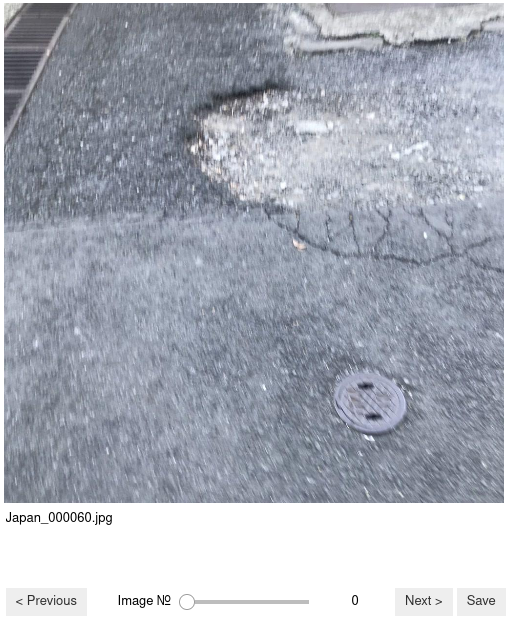

In [ ]:
if not bb.to_dict():
    """Annotate if not manually selected a bbox"""
    bb.app_state.index = 6
    bb.controller.save_current_annotations({
        'x': 298,
        'y': 93,
        'width': 536,
        'height': 430
    })

bb.to_dict()

Let's now create a inital set of road damage images by using the mouse to draw a reactangle containing
the damage on individual images. Below you seed the annotation for a single image.

In [ ]:
img_path, bbox = list(bb.to_dict().items())[0]; print(img_path); print(bbox)

We can now use the bounding box annotations to crop damages from the images and save them in a seperate folder.
The following small function helps us to accomplish this.

In [ ]:
from PIL import Image
from pathlib import Path

def crop_bboxs(bbox_annotations, source_dir, target_dir):
    Path(target_dir).mkdir(parents=True, exist_ok=True)
    for img_file, b in bbox_annotations.items():
        img_file = img_file.split('/')[-1]
        im = Image.open(Path(source_dir)/img_file)
        # box=(left, upper, right, lower)
        box_crop = (b['x'], b['y'], b['x'] + b['width'], b['y'] + b['height'])
        Image.open(Path(source_dir)/img_file).crop(box_crop).save(Path(target_dir)/img_file, quality=95)

In [ ]:
crop_bboxs(bbox_annotations=bb.to_dict(), source_dir='road_japan/images', target_dir='road_japan/images_croped')

Below you can see the croping result from the bbox annotation above.

In [ ]:
Image.open(Path('road_japan/images_croped')/img_path.split('/')[-1])

We first need to decide on the type of damages we want to classify. If we don't know this upfront we can initially create some
dummy labels.

In [ ]:
# create dummy label_images
crop_bboxs(bbox_annotations={k: v for k, v in list(bb.to_dict().items())[:4]}, source_dir='road_japan/images', target_dir='road_japan/class_images')

## 2) Group the damage type in groups using classification labels.

1. We can now use the `Im2ImAnnotator` to quickly explore the cropped images in order to find some typical damage types we are interested in. 
  * The competition list the following types {D00: Longitudinal Crack, D10: Transverse Crack, D20: Aligator Crack, D40: Pothole}.
  * Hint: Check out https://en.wikipedia.org/wiki/Pavement_cracking to find some typical crack types.
2. Select a representative example for each damage type your are interested in and move the file to `road_japan/class_images`.
  * remove the existing dummy images first
  * give the image a nice name illustrative name such as aligator_crack.jpg. The file name is used to create the class labels.
3. Label the images by selecting one or more labels on the right side below "Damage Types".

In [ ]:
from ipyannotator.im2im_annotator import Im2ImAnnotator

In [ ]:
in_p = InputImage(image_dir='images', image_width=600, image_height=500)

out_p = OutputImageLabel(label_dir='images_croped', label_width=100, label_height=100)

annotation_file_path=construct_annotation_path(
    file_name='./road_japan/results/im2im_annotator/annotation.json'
)

im2im = Im2ImAnnotator(
    project_path=project_path,
    input_item=in_p,
    output_item=out_p,
    n_cols=2, 
    n_rows=3, 
    question="Damage Types",
    annotation_file_path=annotation_file_path
)

im2im

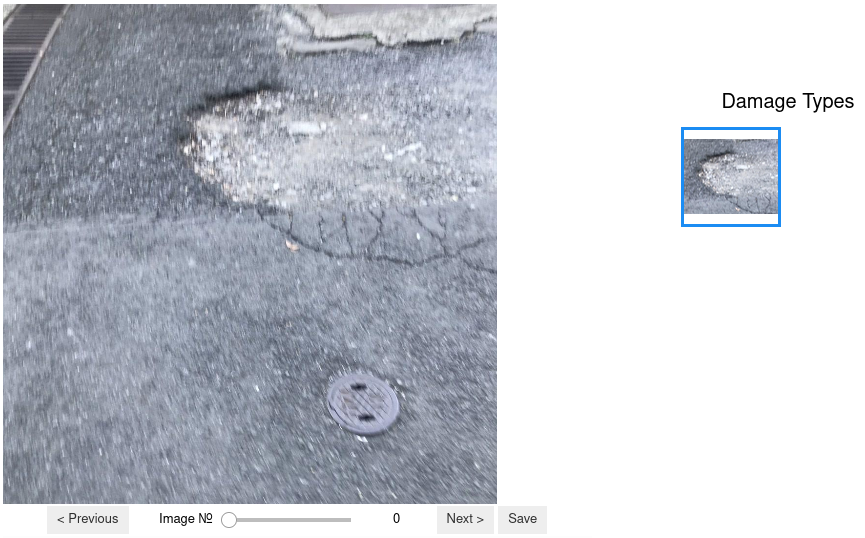

We can now check the class labels that we have just created and save them to a json file.

In [ ]:
from IPython import display
display.JSON(im2im.to_dict())

In [ ]:
if not im2im.to_dict():
    """Annotate if not manually selected a label"""
    im2im.controller.idx_changed(6)
    im2im.im2im_state.annotations = {'road_japan/images_croped/Japan_000060.jpg': {'answer': True}}
    im2im.controller.save_annotations(6)

im2im.to_dict()

In [ ]:
import json
with open('road_japan/classification_labels.json', 'w') as outfile:
    items = im2im.to_dict()
    
    if not items:
        items = {'road_japan/images/Japan_000060.jpg': ['Japan_000060.jpg']}
    
    json.dump(im2im.to_dict(), outfile)

## 3. Refine the inital class labels in a supervision step.

When the data have been labeled initially, supervision is a great way to further improve the data quality by reviewing annotations generated by hand or a
machine learning model.

In [ ]:
# text example data
# image_annotations = {'Japan_000342.jpg': ['Japan_010778.jpg'],
#  'Japan_000541.jpg': ['Japan_011190.jpg'],
#  'Japan_001155.jpg': ['Japan_003206.jpg', 'Japan_010778.jpg'],
#  'Japan_002337.jpg': ['Japan_001155.jpg'],
#  'Japan_003206.jpg': ['Japan_011190.jpg'],
#  'Japan_005979.jpg': ['Japan_010778.jpg'],
#  'Japan_006775.jpg': ['Japan_003206.jpg'],
#  'Japan_007389.jpg': ['Japan_003206.jpg'],
#  'Japan_010778.jpg': ['Japan_003206.jpg', 'Japan_010778.jpg'],
#  'Japan_011190.jpg': ['Japan_001155.jpg', 'Japan_010778.jpg'],
#  'Japan_012213.jpg': ['Japan_011190.jpg']}

We can now use the priviously generated class label to group the images by class.

In [ ]:
with open('road_japan/classification_labels.json') as infile:
    image_annotations= json.load(infile)

In [ ]:
from collections import defaultdict

def group_files_by_class(annotations):
    grouped = defaultdict(list)
    for file, labels in annotations.items():
        for class_ in labels:
            grouped[class_].append(file)
    return grouped

We have the following classes.

In [ ]:
classes_to_files = group_files_by_class(image_annotations); classes_to_files.keys()

In [ ]:
classes_to_files

We can pick any class to start the supervision, we just take the first one here.

In [ ]:
selected_class = list(classes_to_files.keys())[0]; selected_class

In [ ]:
from ipyannotator.capture_annotator import CaptureAnnotator

In [ ]:
html_question = 'Select images that don\'t belong to class <span style="color: red;">{}</span>'.format(selected_class)

The annotator now shows us a grid of images annotated as belonging to the same class. You can now quickly click through
this batches and select the images that belong in a different class.

In [ ]:
in_p = InputImage(image_dir='images', image_width=150, image_height=150)

out_p = OutputGridBox()

annotation_file_path=construct_annotation_path(
    file_name='./road_japan/results/capture_annotator/annotation.json'
)

ca = CaptureAnnotator(
    project_path=project_path, 
    input_item=in_p,
    output_item=out_p, 
    n_cols=2, 
    n_rows=2,
    question=html_question,
    filter_files=classes_to_files[selected_class],
    annotation_file_path=annotation_file_path
)

ca

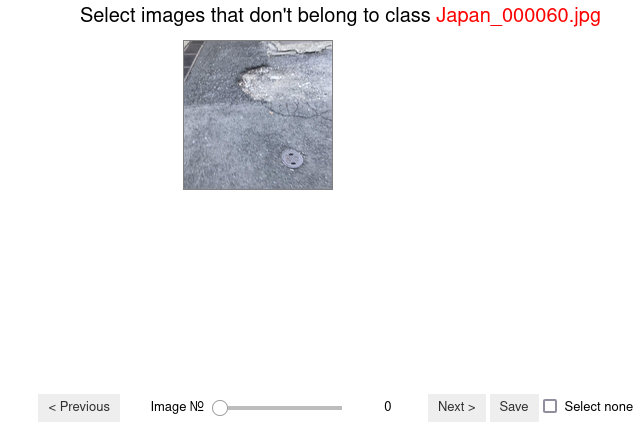

You can repeat this process for each class and then reclassify the wrong labels in a later step. The Capture annotator is most useful when you already
have imperfect image classifications for example form an pretrained model or you have many less experienced annotators and a limited amount of experts to check there work. 

In [ ]:
ca.to_dict()

## Conclusion

This short tutorial has demonstrated how annotation UI's already included in ipyannotator can be used to quickly annotate images.
Clearly these a very simple examples and the real power of using the ipyannotator concept lays in building project specific UI's.
Check out the other notebooks to get inspired how this can be done.